In [10]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.draw import line_aa
from scipy.ndimage import binary_dilation

In [2]:
acc_skels = np.load("/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/crops/2mm/CINGULATE/mask/Rskeleton.npy")
acc_skels = np.where(acc_skels >= 1, 1, 0)
print(np.unique(acc_skels))
acc_skels.shape

[0 1]


(341, 17, 40, 38, 1)

In [3]:
def compute_aggregated_skel(skels, threshold):
    """Compute the mean of skels voxel by voxel, then keep only the most represented voxels,
    i.e. the (1-threshold)*100 % with highest occurence."""
    mean_skel = np.squeeze(np.mean(skels, axis=0))

    # keep only the most represented voxels and binarize
    max_vox = np.max(mean_skel)
    agg_skel = np.where(mean_skel > max_vox*(1-threshold), mean_skel, 0)

    return agg_skel

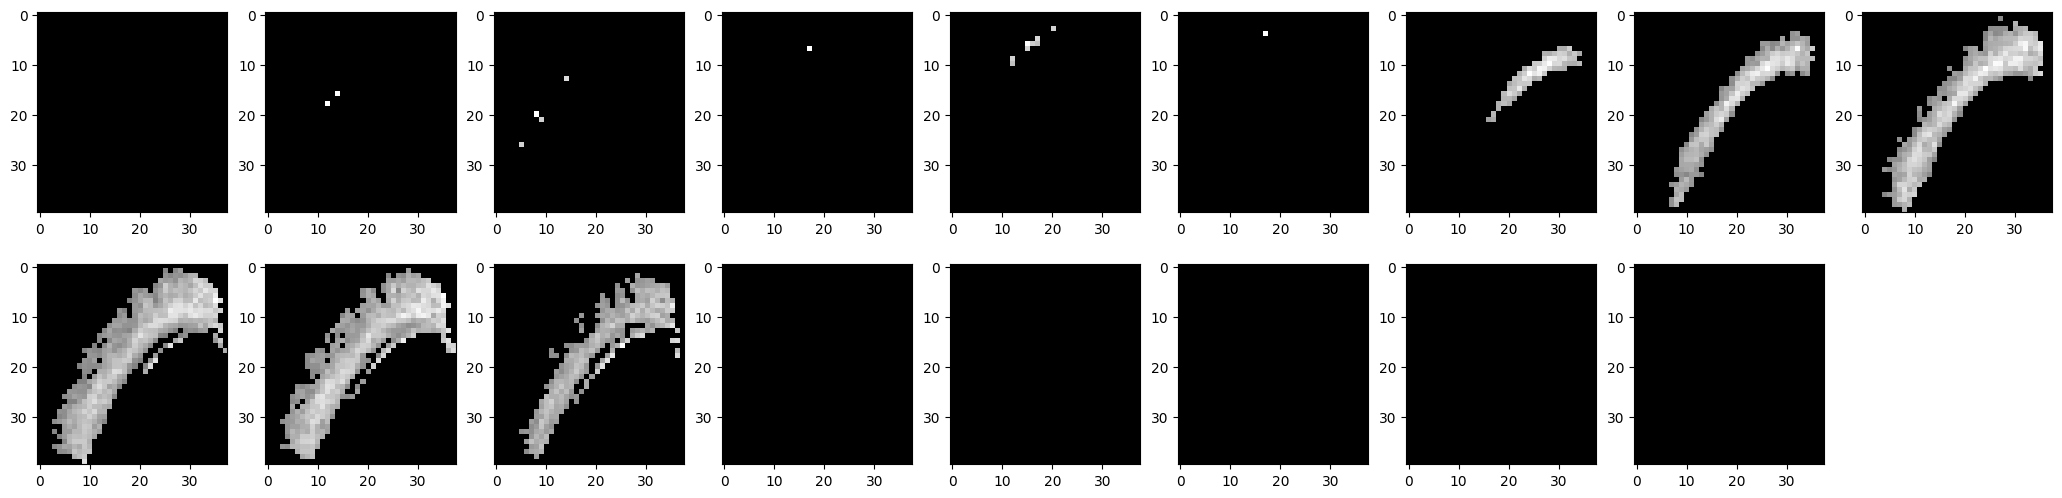

In [4]:
mean_skel = compute_aggregated_skel(acc_skels, 0.5)

plt.figure(figsize=(26,6))
for i in range(17):
    plt.subplot(2,9,i+1)
    plt.imshow(mean_skel[i], cmap='gray')
plt.show()

Voxels à enlever :
- sur les couches 9 à 11

In [5]:
tache = np.zeros(mean_skel.shape)
tache[9,20,30] = 10
np.unique(tache)

array([ 0., 10.])

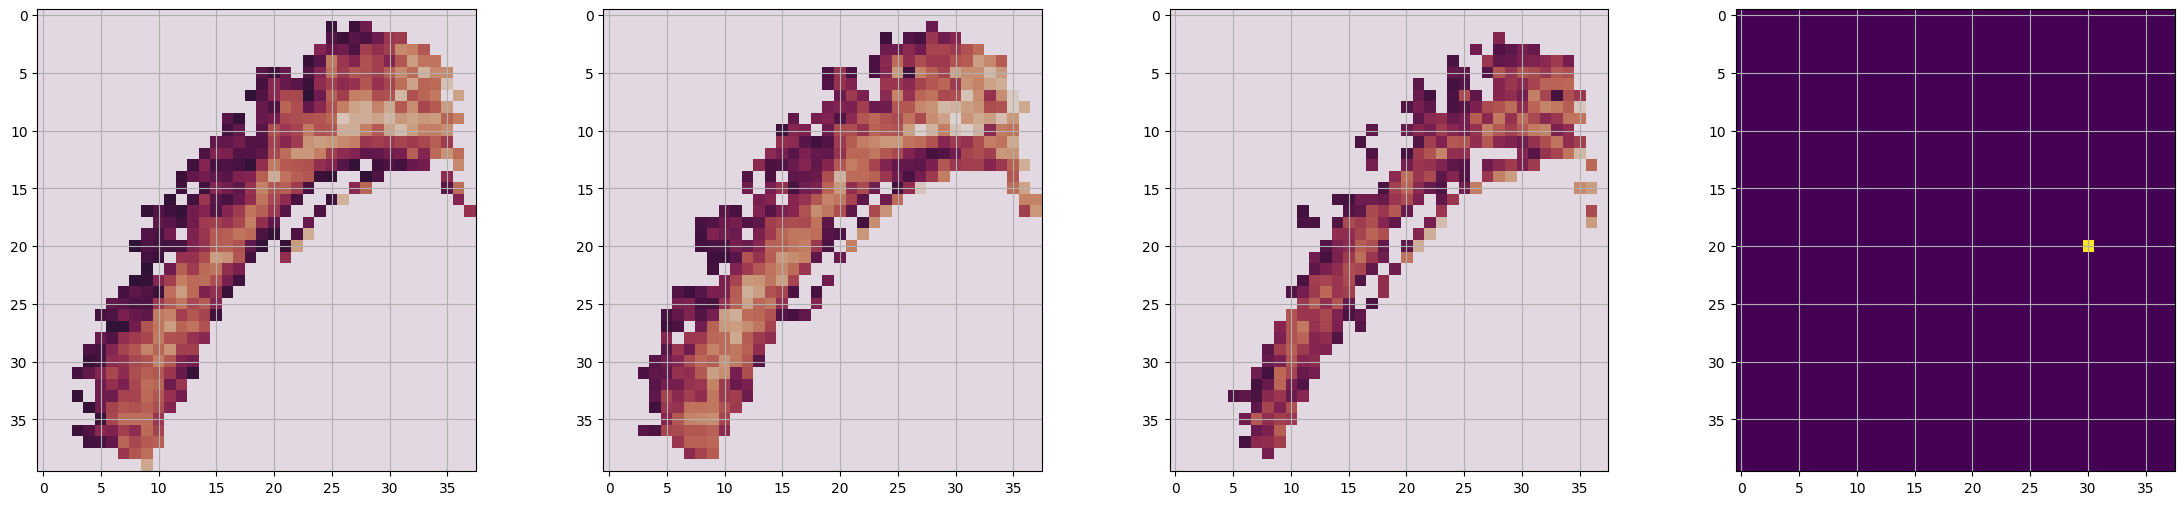

In [6]:
plt.figure(figsize=(28,6))

for i in range(9,12):
    plt.subplot(1,4,i-8)
    plt.imshow(mean_skel[i], cmap='twilight')
    ax = plt.gca()
    ax.grid()

# plot la tache pour savoir l'ordre des axes
plt.subplot(1,4,4)
plt.imshow(tache[9])
ax = plt.gca()
ax.grid()

plt.show()

Cubes à enlever :
- couche 9 : de [21,21] à [13,30]
- couche 10 : de [26,16] à [14,29]
- couche 11 : de [27,16] à [12,31]

In [13]:
def create_mask_line(x1,y1,x2,y2,dilate=1):
    rr, cc, val = line_aa(x1,y1,x2,y2)
    mask = np.zeros(mean_skel.shape[1:])
    mask[rr,cc] = val

    # binarize mask
    mask = np.where(mask > 0, 1, 0)

    # dilate
    if dilate > 0:
        mask = binary_dilation(mask, iterations=dilate)

    return mask

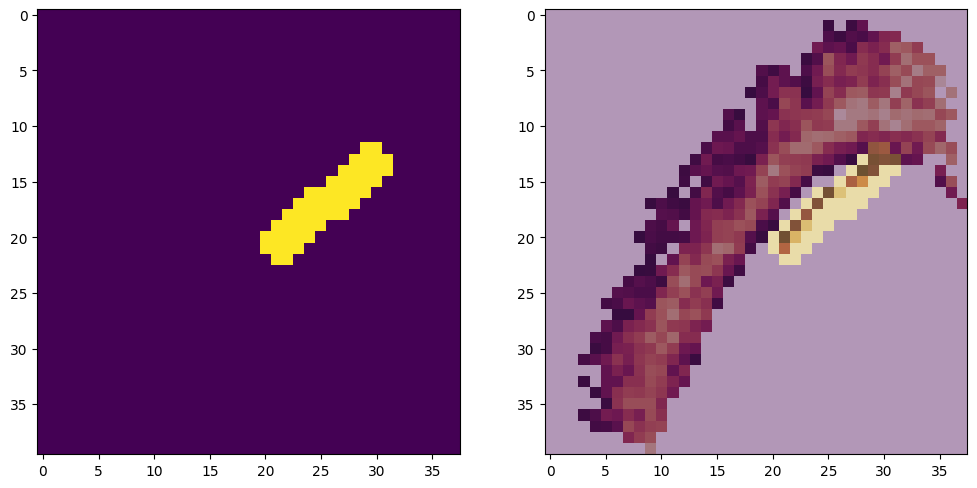

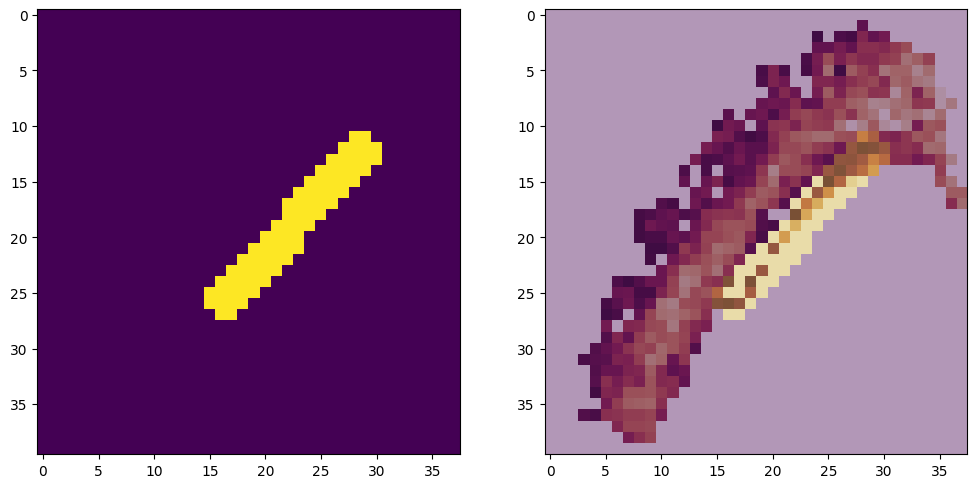

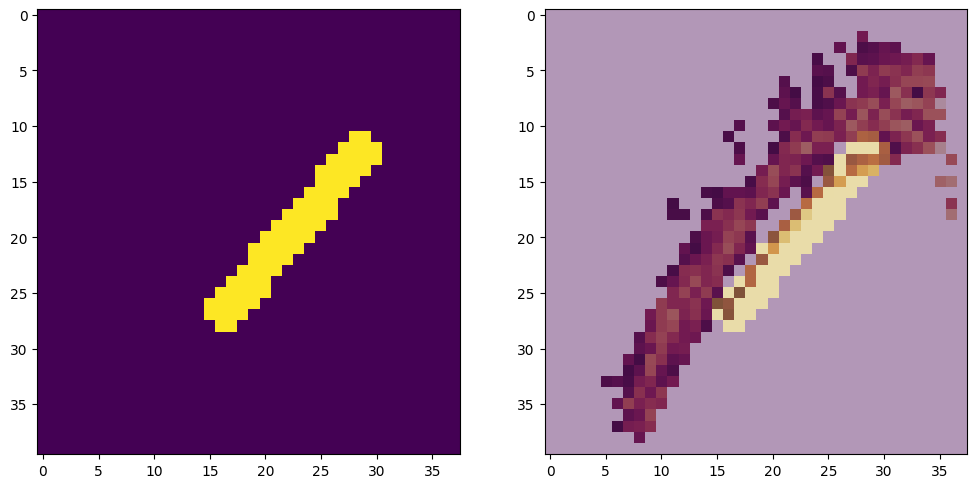

In [32]:
mask9 = create_mask_line(21,21,13,30)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(mask9)
plt.subplot(1,2,2)
plt.imshow(mean_skel[9], cmap='twilight')
plt.imshow(mask9, alpha=0.3)


mask10 = create_mask_line(26,16,12,29)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(mask10)
plt.subplot(1,2,2)
plt.imshow(mean_skel[10], cmap='twilight')
plt.imshow(mask10, alpha=0.3)


mask11 = create_mask_line(27,16,12,29,dilate=1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(mask11)
plt.subplot(1,2,2)
plt.imshow(mean_skel[11], cmap='twilight')
plt.imshow(mask11, alpha=0.3)

In [33]:
full_mask = np.zeros(mean_skel.shape)
full_mask[9,:,:] = mask9
full_mask[10,:,:] = mask10
full_mask[11,:,:] = mask11
full_mask = np.expand_dims(full_mask, axis=-1)
print(full_mask.shape)

(17, 40, 38, 1)


In [38]:
# reload acc_skels to have the roght values
acc_skels = np.load("/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/crops/2mm/CINGULATE/mask/Rskeleton.npy")

masked_skels = np.zeros(acc_skels.shape)

for i,skel in enumerate(acc_skels):
    masked_skel = np.where(full_mask > 0, 0, skel)
    masked_skels[i,...] = masked_skel

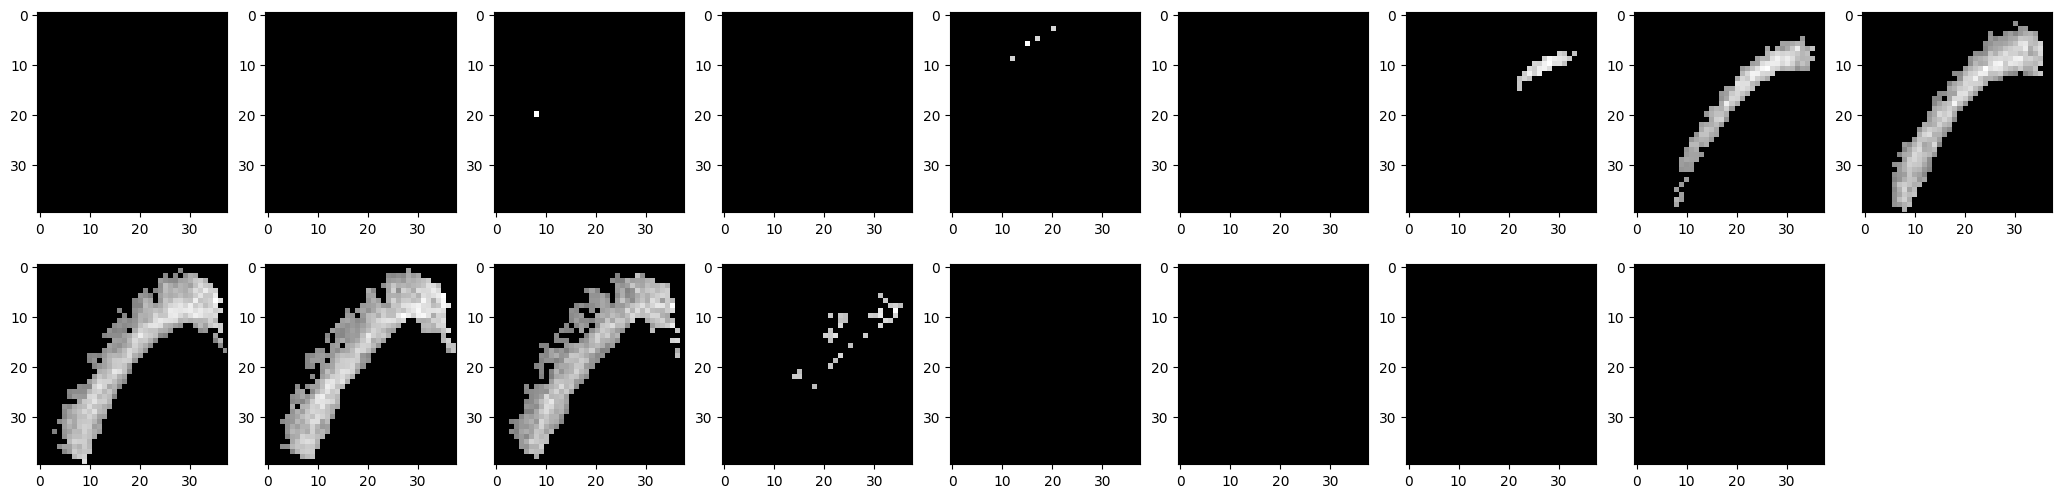

In [39]:
mean_masked_skel = compute_aggregated_skel(masked_skels, 0.5)

plt.figure(figsize=(26,6))
for i in range(17):
    plt.subplot(2,9,i+1)
    plt.imshow(mean_masked_skel[i], cmap='gray')
plt.show()

In [40]:
np.save("/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/crops/2mm/CINGULATE/mask/Rskeleton_no_cal.npy", masked_skels)